# Run abricate for each database and create summaries

#### Author: Liubov Chuprikova

In [1]:
# import modules
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.getdefaultencoding()

'utf-8'

In [2]:
# functions and variables
ABRICATE_PATH = '/home/liubov/repos/abricate/bin/abricate'
GENOMES_PATH = '/home/liubov/Documents/tfm/the_whole_analysis/all_genomes'
WORKING_DIR = '/home/liubov/Documents/tfm/the_whole_analysis/abricate_analysis'

def get_abricate_databases():
    """
    Run `abricate --list` and parse available databases from stdout.
    """
    abricate_list = subprocess.run([ABRICATE_PATH, '--list'],
                                   stdout=subprocess.PIPE, 
                                   stderr=subprocess.STDOUT).stdout.decode('utf-8')
    databases = []
    for line in abricate_list.split('\n'):
        entry = line.split('\t')[0]
        if entry != 'DATABASE' and entry != '':
            databases.append(entry)
    return databases

def run_abricate(database_dir, genomes_dir):
    """
    Screen all the genomes in the genomes_dir against the given database.
    """
    snp_databases = ['fumC', 'fimH', 'pointFinder_Ecoli']
    # %id=95 (https://cge.cbs.dtu.dk/services/CHTyper/)
    # %id=85 %cov=60 (https://cge.cbs.dtu.dk/services/SerotypeFinder/)
    db = os.path.basename(database_dir)
    if db in snp_databases: 
        minid, mincov = '95', '95'
    elif db == 'ecoh':
        minid, mincov = '85', '60'
    else:   # default
        minid, mincov = '75', '0'
    in_genomes = os.listdir(genomes_dir)
    os.mkdir(database_dir)
    for genome in in_genomes:
        print(f'\nRunning for the genome {genome}...')
        with open(os.path.join(database_dir, f'{genome[:-3]}.tab', ), 'w') as ouf:
            subprocess.run([ABRICATE_PATH, '--db', db, 
                            '--minid', minid, '--mincov', mincov,
                            '--threads', '4', '--nopath', 
                            f'{os.path.join(genomes_dir, genome)}'], stdout=ouf)

def abricate_summarize(databases, out_dir):
    summaries_dir = os.path.join(out_dir, 'summaries')
    
    if not os.path.exists(summaries_dir):
        os.mkdir(summaries_dir)
    
    for db in databases:
        db_out_path = os.path.join(out_dir, db)
        if not os.path.isdir(db_out_path):
            continue
        if os.path.isfile(os.path.join(summaries_dir, f'{db}.tab')):
            continue
        db_out_files = ' '.join([os.path.join(db_out_path, file) for file in os.listdir(db_out_path)])
        with open(os.path.join(summaries_dir, f'{db}.tab'), 'w') as ouf:
            subprocess.run(f'{ABRICATE_PATH} --nopath --summary {db_out_files}',
                           shell=True, stdout=ouf)

def parse_summaries(databases, summaries_dir):
    summaries_data = pd.DataFrame(columns=databases, 
                                      index=[f'{file[:-3]}.tab' for file in os.listdir(GENOMES_PATH)])
    for db in databases:
        summary_file = os.path.join(summaries_dir, f'{db}.tab')
        if not os.path.isfile(summary_file):
            continue
        with open(summary_file) as inf:
            for line in inf:
                if line[0] != '#':
                    genome, number = line.strip().split(sep='\t')[:2]
                    summaries_data.at[genome, db] = number

    return summaries_data

def set_chtype(from_df, to_df, chtype):
    for _, row in from_df.iterrows():
        entry = row['#FILE']
        index_array = np.flatnonzero(row.iloc[2:].notna()) + 2
        if len(index_array) > 1:
            raise AssertionError('More than a single variation locus was defined!')
        if len(index_array) == 0:
            entry_type = np.nan
        else:
            entry_type = row.index[index_array[0]]
        to_df.at[entry, chtype] = entry_type

def set_ohtype(from_df, to_df):
    for _, row in from_df.iterrows():
        entry = row['#FILE']
        index_array = np.flatnonzero(row.iloc[2:].notna()) + 2
        entry_types = [row.index[index] for index in index_array]
        to_df.at[entry, 'ecoh'] = ';'.join([etype for etype in entry_types])

def plot_counts_by_type(types_ndarray):
    types, counts = np.unique(types_ndarray, return_counts=True)
    counts_sorted = np.sort(counts)[::-1]
    types_sorted = types[(-counts).argsort()]
    plt.bar(x=types_sorted, height=counts_sorted)
    plt.ylim(top=np.max(counts))
    plt.xticks(rotation=90)
    
    return plt.show()

### 1. Run abricate with all available databases and summarize the output

In [3]:
abricate_dbs = get_abricate_databases()
[i for i in abricate_dbs]

['ecoli_virfinder',
 'ecoh',
 'vfdb',
 'megares_noSNPs',
 'integron',
 'argannot',
 'fumC',
 'ncbi',
 'card',
 'resfinder',
 'fimH',
 'ecoli_vf',
 'plasmidfinder']

In [4]:
for database in abricate_dbs:
    db_dir = os.path.join(WORKING_DIR, database)
    if not os.path.isdir(db_dir):
        print(f'\n>>>Running for the database {os.path.basename(db_dir)}')
        run_abricate(db_dir, GENOMES_PATH)

In [5]:
abricate_summarize(abricate_dbs, WORKING_DIR)
summaries = parse_summaries(abricate_dbs, os.path.join(WORKING_DIR, 'summaries'))

### 2. Define *fimH* and *fumC* types

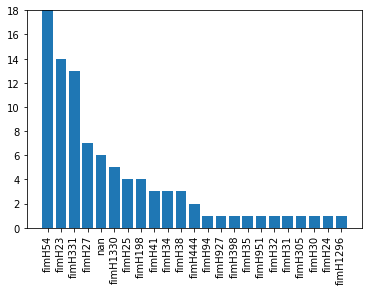

In [6]:
fimh_summary = pd.read_csv(os.path.join(WORKING_DIR, 'summaries', 'fimH.tab'), 
                               sep='\t', na_values='.')

set_chtype(fimh_summary, summaries, 'fimH')

plot_counts_by_type(summaries['fimH'].to_numpy(dtype=str))

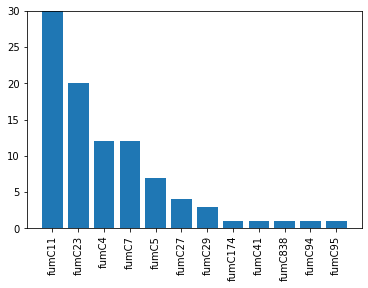

In [7]:
fumc_summary = pd.read_csv(os.path.join(WORKING_DIR, 'summaries', 'fumC.tab'),
                               sep='\t', na_values='.')

set_chtype(fumc_summary, summaries, 'fumC')

plot_counts_by_type(summaries['fumC'].to_numpy(dtype=str))

### 3. Define *OH* serotypes

In [8]:
ecoh_summary = pd.read_csv(os.path.join(WORKING_DIR, 'summaries', 'ecoh.tab'),
                              sep='\t', na_values='.')

set_ohtype(ecoh_summary, summaries)

# It'll be easier to edit OH-types manually!

In [9]:
# uncomment to rewrite the file
summaries.to_csv(os.path.join(WORKING_DIR, 'short_summary.csv'))